In [2]:
# Import pandas 
import pandas as pd
pd.reset_option('display.max_columns')

# Groups of columns we want to use in our model
applicant_numeric=['annual_inc','dti','age_earliest_cr','loan_amnt', 'installment']
applicant_categorical=['application_type', 'emp_length', 'home_ownership', 'addr_state', 'term']
credit_numeric=['acc_now_delinq','acc_open_past_24mths','avg_cur_bal','bc_open_to_buy',
                'bc_util','delinq_2yrs','delinq_amnt','fico_range_high','fico_range_low',
                'last_fico_range_high','last_fico_range_low','open_acc','pub_rec','revol_util',
                'revol_bal','tot_coll_amt','tot_cur_bal','total_acc','total_rev_hi_lim',
                'num_accts_ever_120_pd','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats',
                'num_bc_tl','num_il_tl', 'num_rev_tl_bal_gt_0','pct_tl_nvr_dlq',
                'percent_bc_gt_75','tot_hi_cred_lim','total_bal_ex_mort','total_bc_limit',
                'total_il_high_credit_limit','total_rev_hi_lim','all_util', 'loan_to_income',
                'installment_pct_inc','il_util','il_util_ex_mort','total_bal_il','total_cu_tl']
label = ['grade']

# Read in lending club data 
# ...skip the columns we're not going to use to preserve memory
lcdata = pd.read_csv("/tmp/lcdata/lc-2015-loans.csv", 
                     low_memory=False, 
                     usecols=applicant_numeric + applicant_categorical + credit_numeric + label)


print(lcdata.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421095 entries, 0 to 421094
Data columns (total 50 columns):
loan_amnt                     421095 non-null int64
term                          421095 non-null object
installment                   421095 non-null float64
grade                         421095 non-null object
emp_length                    421095 non-null object
home_ownership                421095 non-null object
annual_inc                    421095 non-null float64
addr_state                    421095 non-null object
dti                           421095 non-null float64
delinq_2yrs                   421095 non-null int64
fico_range_low                421095 non-null int64
fico_range_high               421095 non-null int64
open_acc                      421095 non-null int64
pub_rec                       421095 non-null int64
revol_bal                     421095 non-null int64
revol_util                    421095 non-null float64
total_acc                     421095 non-nul

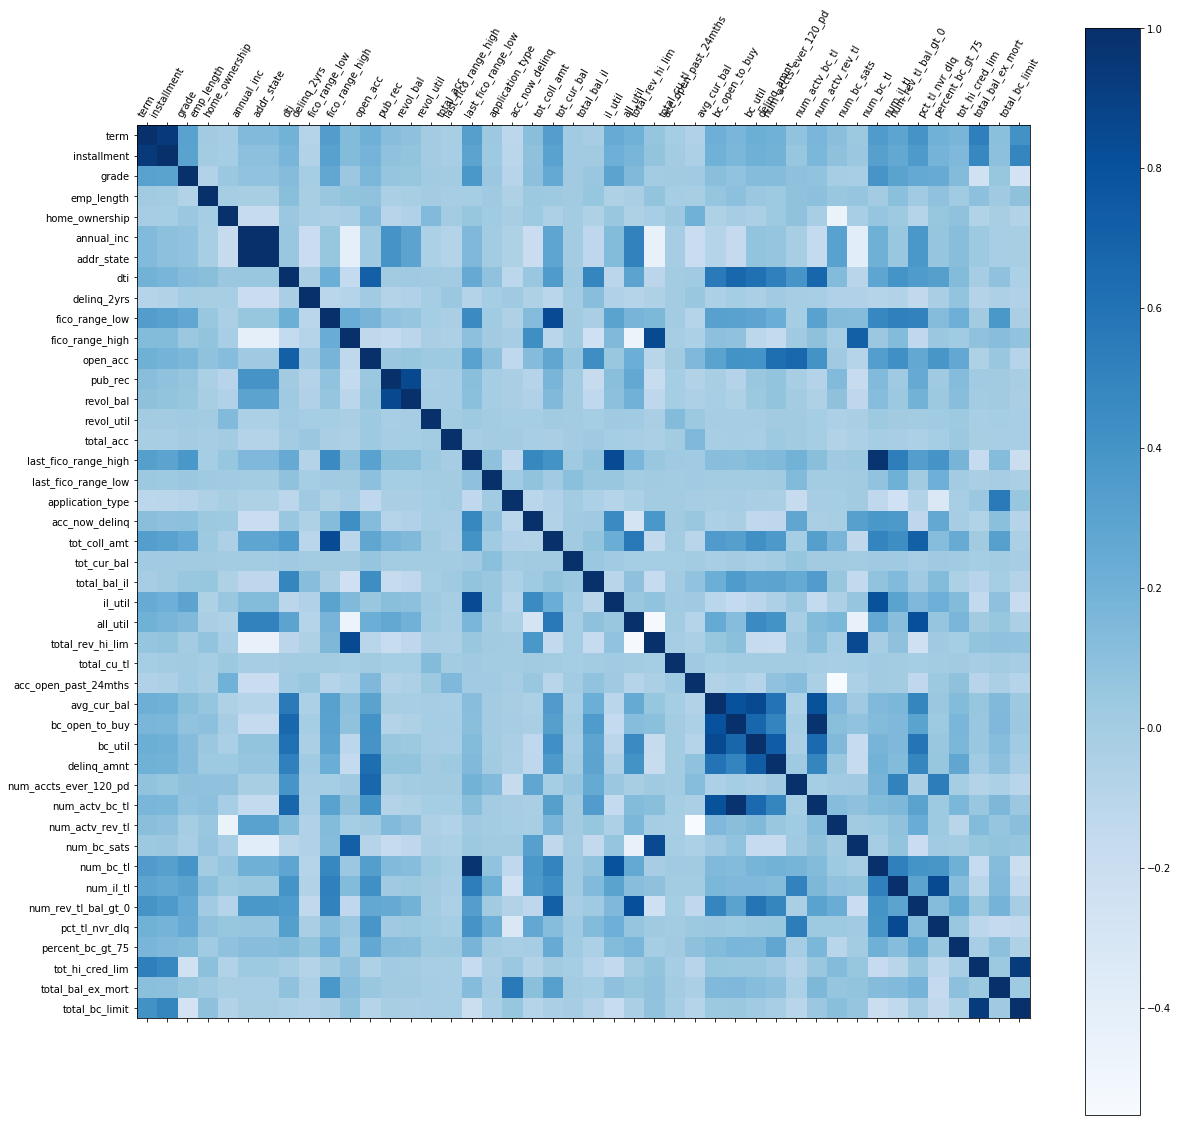

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Sanity check that we're working with cleaned data
bad_rows = lcdata.isnull().T.any().T.sum()
if bad_rows > 0:
    print("Rows with null/NaN values: {}".format(bad_rows))
    print("Columns with null/NaN values:")
    pd.isnull(lcdata).sum() > 0
    print ("Dropping bad rows...")
    lcdata.dropna(axis=0, how='any', inplace=True)
    print("Rows with null/NaN values: {}".format(lcdata.isnull().T.any().T.sum()))
    
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
cax = ax.matshow(lcdata.corr(), cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xticklabels(lcdata, rotation=60)
ax.set_yticklabels(lcdata)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [6]:
# Check for an environment variable called "sample"
# When present, select a sample of the rows for processing
# to avoid painfully slow processing in local testing
import os

sample = os.environ.get("sample")
if sample != None:
    print("Using only a sample of {} observations".format(sample))
    data = lcdata.sample(int(60000))
else:
    print("Using the full set of {} observations".format(lcdata.shape[0]))
    data = lcdata

Using only a sample of 50000 observations


In [7]:
# Subset the data to get unlabeled observations 
X=data.loc[:, applicant_numeric + applicant_categorical + credit_numeric]

# function to one-hot encode categorical features
def encode_categorical(x, categorical_cols):
    label_data = None
    cat_data = None
    for col in categorical_cols:
        # use get_dummies() to do one hot encoding of categorical column
        x = x.merge(pd.get_dummies(x[col]), left_index=True, right_index=True)
        
        # drop the original categorical column
        x.drop(col, axis=1, inplace=True)
        
    print(x.shape)
    return x

# Update our X dataframe with categorical values replaced by one-hot encoded values
X = encode_categorical(X, applicant_categorical)

# Ensure all numeric features are on the same scale
for col in applicant_numeric + credit_numeric:
    X[col] = (X[col] - X[col].mean())/X[col].std()

print(X.sample())

(60000, 113)
        annual_inc       dti  age_earliest_cr  loan_amnt  installment  \
298035    0.832538 -1.026249         -0.71517   0.378249     0.014705   

        acc_now_delinq  acc_open_past_24mths  avg_cur_bal  bc_open_to_buy  \
298035       -0.073494              0.739079     1.682857       -0.409502   

         bc_util     ...      TX  UT  VA  VT  WA  WI  WV  WY   36 months  \
298035 -0.159621     ...       0   0   0   0   0   0   0   0           0   

         60 months  
298035           1  

[1 rows x 113 columns]


In [8]:
# Specify the target labels and flatten the array 
y=pd.get_dummies(data.grade)
print(y.sample())

       A  B  C  D  E  F  G
45629  0  1  0  0  0  0  0


In [9]:
from sklearn.model_selection import train_test_split

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=23)

print(X_train.head())


        annual_inc       dti  age_earliest_cr  loan_amnt  installment  \
91030    -0.087611  0.126276        -0.682338   0.086608     0.404411   
189542   -0.455671  2.377212        -0.561832   0.203264    -0.237855   
189366   -0.455671 -0.140842         0.382730  -0.380018    -0.266678   
61196    -0.148954 -1.385477        -1.165443  -0.939969    -0.856801   
82559    -0.326850  2.045616         0.317065   0.217846    -0.021416   

        acc_now_delinq  acc_open_past_24mths  avg_cur_bal  bc_open_to_buy  \
91030        -0.073494              1.055053    -0.258356       -0.186385   
189542       -0.073494             -1.156765    -0.347834        0.065110   
189366       -0.073494             -1.156765    -0.621723        0.035523   
61196        -0.073494              0.423105    -0.589867       -0.168498   
82559        -0.073494              1.687002    -0.244268       -0.064874   

         bc_util     ...      TX  UT  VA  VT  WA  WI  WV  WY   36 months  \
91030  -0.046427     .

In [10]:
# Import `Sequential` from `keras.models`
from keras.models import Sequential

# Import `Dense` from `keras.layers`
from keras.layers import Dense, Dropout

from keras.constraints import maxnorm

print(y.shape[1])

def baseline_model():
    # create model
    model = Sequential()
    # input layer
    model.add(Dense(100, input_dim=X.shape[1], activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    
    # hidden layer
    model.add(Dense(100, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    
    # output layer
    model.add(Dense(y.shape[1], activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = baseline_model()
history = model.fit(X_train.as_matrix(), y_train.as_matrix(), validation_split=0.2, epochs=40, batch_size=32, verbose=2)

Using TensorFlow backend.


7
Train on 33600 samples, validate on 8400 samples
Epoch 1/40
2s - loss: 1.3308 - acc: 0.4282 - val_loss: 1.1882 - val_acc: 0.4904
Epoch 2/40
2s - loss: 1.1382 - acc: 0.5006 - val_loss: 0.9924 - val_acc: 0.5694
Epoch 3/40
1s - loss: 0.9645 - acc: 0.5714 - val_loss: 0.8034 - val_acc: 0.6579
Epoch 4/40
2s - loss: 0.8240 - acc: 0.6417 - val_loss: 0.6509 - val_acc: 0.7418
Epoch 5/40
2s - loss: 0.7152 - acc: 0.6910 - val_loss: 0.5756 - val_acc: 0.7667
Epoch 6/40
2s - loss: 0.6429 - acc: 0.7208 - val_loss: 0.5214 - val_acc: 0.7751
Epoch 7/40
2s - loss: 0.5920 - acc: 0.7436 - val_loss: 0.4735 - val_acc: 0.8021
Epoch 8/40
2s - loss: 0.5581 - acc: 0.7611 - val_loss: 0.4534 - val_acc: 0.8188
Epoch 9/40
2s - loss: 0.5372 - acc: 0.7705 - val_loss: 0.4209 - val_acc: 0.8329
Epoch 10/40
2s - loss: 0.5106 - acc: 0.7831 - val_loss: 0.4237 - val_acc: 0.8221
Epoch 11/40
2s - loss: 0.4941 - acc: 0.7877 - val_loss: 0.3985 - val_acc: 0.8393
Epoch 12/40
2s - loss: 0.4827 - acc: 0.7924 - val_loss: 0.3878 - va

dict_keys(['loss', 'acc', 'val_acc', 'val_loss'])


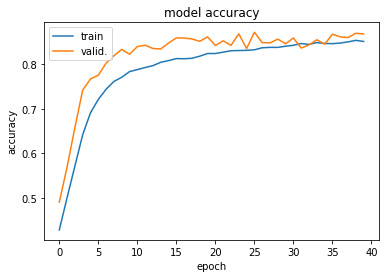

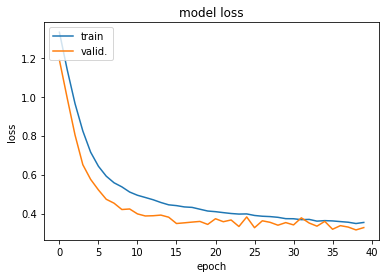

In [11]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid.'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid.'], loc='upper left')
plt.show()

In [13]:
import numpy as np

y_pred = model.predict(X_test.as_matrix())

y_pred_classes = pd.DataFrame((y_pred.argmax(1)[:,None] == np.arange(y_pred.shape[1])), columns=y_test.columns,index=y_test.index)

score = model.evaluate(X_test.as_matrix(), y_test.as_matrix(), verbose=2)

print("Test Set Loss: {:.00%}, Accuracy: {:.00%}".format(score[0], score[1]))

Test Set Loss: 32%, Accuracy: 87%


0.868853168068


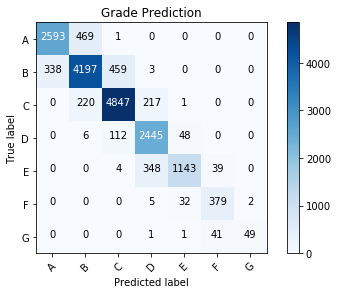

In [14]:
# Import the modules from `sklearn.metrics`
from sklearn.metrics import confusion_matrix, f1_score

# F1 score
# Use idxmax() to convert back from one-hot encoding
f1 = f1_score(y_test.idxmax(1), y_pred_classes.idxmax(1), average='weighted')
print(f1)

# Confusion matrix
cfn_matrix = confusion_matrix(y_test.idxmax(1), y_pred_classes.idxmax(1))

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cfn_matrix, classes=y_test.columns,
                      title='Grade Prediction')
plt.show()